# PSTAT 135 Group Project

##### Group 19: Adam Alcala, Yixuan Li, Alexis Navarra Richard Zhao

#### For our group project, we wanted to start by considering the question: Is there a connection between education level and voter turnout?
##### We feel that this will be an interesting connection because of the known influence that education can make on if a person decides to vote or not, and how they decide to vote if so. For the rest of our project, we will aim to observe the relationship not only between education level and voter turnout across a state, but to see if these also have any significant relationships with region, political party, income, and more.

In [55]:
# libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

##### We will begin EDA for our project by using one single state's voter data, and as we continue to work on our project, we can expand our exploration to other states and compare them to each other. For now, we will start by exploring the Wyoming dataset.

In [17]:
## read in parquet files
bucket_dir = 'gs://pstat135-voter-file/VM2Uniform/'
WY_fulldf = spark.read.parquet(bucket_dir + 'VM2Uniform--WY--2021-01-13')

##### The provided voter datasets for the project have many variables, so in order to make our dataset more workable, we decided to limit it down to fields that we felt would be relevant to our specific exploration of education level. Additionally, because the amount of election data included in the dataset, we decided to limit our EDA down to specifically the 2016 Presidentialelection. Below is a list of all of these relevant fields:

- LALVOTERID
- County
- Board_of_Education_District
- County_Board_of_Education_District
- CommercialData_Education
- CommercialData_AreaMedianEducationYears
- CommercialDataLL_Interest_in_Education_Online_In_Household
- ElectionReturns_G16_Cnty_Margin_Clinton_D
- ElectionReturns_G16_Cnty_Percent_Clinton_D
- ElectionReturns_G16_Cnty_Vote_Clinton_D
- ElectionReturns_G16_Cnty_Margin_Trump_R
- ElectionReturns_G16_Cnty_Percent_Trump_R
- ElectionReturns_G16_Cnty_Vote_Trump_R
- ElectionReturns_G16CountyTurnoutAllRegisteredVoters
- ElectionReturns_G16CountyTurnoutDemocrats
- ElectionReturns_G16CountyTurnoutIndependentsAllOthers
- ElectionReturns_G16CountyTurnoutRepublicans


In [18]:
keep = ['LALVOTERID', 'County', 'Board_of_Education_District', 'County_Board_of_Education_District', 'CommercialData_Education',
        'CommercialData_AreaMedianEducationYears', 'CommercialDataLL_Interest_in_Education_Online_In_Household',
        'ElectionReturns_G16_Cnty_Margin_Clinton_D', 'ElectionReturns_G16_Cnty_Percent_Clinton_D', 
        'ElectionReturns_G16_Cnty_Vote_Clinton_D', 'ElectionReturns_G16_Cnty_Margin_Trump_R',
        'ElectionReturns_G16_Cnty_Percent_Trump_R', 'ElectionReturns_G16_Cnty_Vote_Trump_R',
        'ElectionReturns_G16CountyTurnoutAllRegisteredVoters', 'ElectionReturns_G16CountyTurnoutDemocrats',
        'ElectionReturns_G16CountyTurnoutIndependentsAllOthers', 'ElectionReturns_G16CountyTurnoutRepublicans']
WY_df = WY_fulldf.select(keep)

##### We decided to take a closer look at some of the columns we viewed as most important (Voter ID and County) to see if there were any missing values.

<AxesSubplot:>

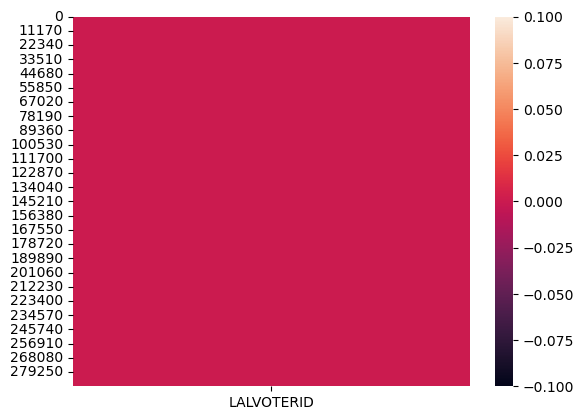

In [60]:
# select WY voter IDs
ID_list = WY_df.select('LALVOTERID')
ID_list_pd = ID_list.toPandas()
# Convert all values to T/F
ID_tf = ID_list_pd.isnull()
# Plot it
sns.heatmap(data=ID_tf)

<AxesSubplot:>

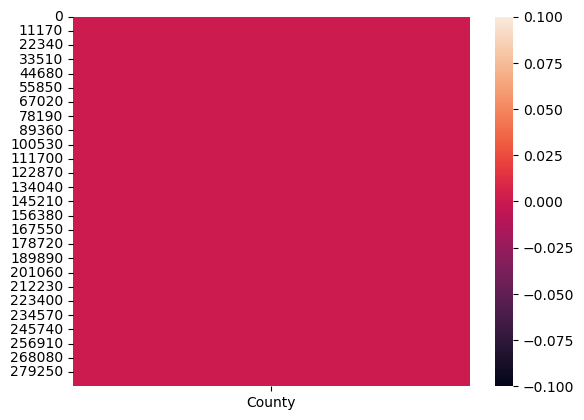

In [61]:
# select WY counties
county_list = WY_df.select('County')
county_list_pd = county_list.toPandas()
# Convert all values to T/F
county_tf = county_list_pd.isnull()
# Plot it
sns.heatmap(data=county_tf)

##### From the heatmaps above, we can see that there is no apparent missing values in the Voter ID or County columns.

##### We want to take a closer look at the specific variable containing voter education level, which is 'CommercialData_Education'. We noticed that the variable has a degree of possibility for each education level: 'Likely' vs. 'Extremely Likely'. We decided to remove this degree of possibility from the variable so that our exploration of the groups within the state was a little more concise. We did this by creating the new 'Education_Lvl' variable.

In [19]:
## clean education level column
ed_lvl_combine = when(WY_df.CommercialData_Education.like('Grad Degree%'), 'Grad Degree')\
                .when(WY_df.CommercialData_Education.like('Bach Degree%'), 'Bach Degree')\
                .when(WY_df.CommercialData_Education.like('Vocational Technical Degree%'), 'Vocational Technical Degree')\
                .when(WY_df.CommercialData_Education.like('Some College%'), 'Some College')\
                .when(WY_df.CommercialData_Education.like('HS Diploma%'), 'HS Diploma')\
                .when(WY_df.CommercialData_Education.like('Less than HS Diploma%'), 'Less Than HS Diploma')\
                .otherwise('Null')
WY_df = WY_df.withColumn("Education_Lvl", ed_lvl_combine)

##### Next, we wanted to take a look at the distribution of education level of voters across the entire state of Wyoming. We obtained the raw count of voters in each education level, as well as their respective proportion of the total voters within the state.

In [22]:
## find counts and proportions of each level of education for the state of Wyoming
from pyspark.sql.functions import col, countDistinct, round, when

total_state_voters = WY_df.select('LALVOTERID').count()
print('The total number of voters in the state of Wyoming:', total_state_voters)

ed_lvl_st_cnt = WY_df.groupBy(['Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_st_cnt = ed_lvl_st_cnt.withColumnRenamed('count(LALVOTERID)', 'num_voters')
ed_lvl_state = ed_lvl_st_cnt.withColumn('prcnt_of_total', round(((col('num_voters')/total_state_voters)*100), 2))
ed_lvl_state.show()

The total number of voters in the state of Wyoming: 290408


+--------------------+----------+--------------+
|       Education_Lvl|num_voters|prcnt_of_total|
+--------------------+----------+--------------+
|Less Than HS Diploma|      5875|          2.02|
|          HS Diploma|     53446|          18.4|
|         Bach Degree|     47700|         16.43|
|         Grad Degree|     24520|          8.44|
|Vocational Techni...|       374|          0.13|
|        Some College|     53566|         18.45|
|                Null|    104927|         36.13|
+--------------------+----------+--------------+



<AxesSubplot:ylabel='Education_Lvl'>

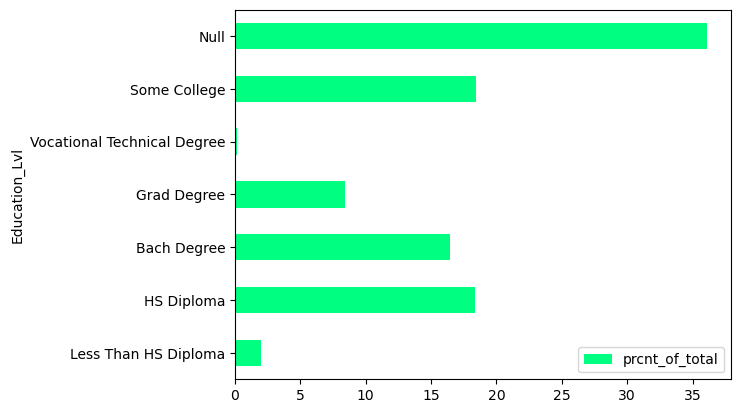

In [23]:
## visualize above
ed_lvl_state_pd = ed_lvl_state.toPandas()
ed_lvl_state_pd.plot(kind='barh', x='Education_Lvl', y='prcnt_of_total', colormap='winter_r')

##### We found that out of the total number of voters in Wyoming (290408), the majority of those voters (18.45%) were listed as having completed 'Some College', aside from the proportion of voters who had null education level values (36.13%). We will have to decide in the future of working on our project what to do with these null values; it seems that the best solution might be to drop them because we still have a good portion of data to work with. As of right now in our exploration, we will proceed as normal with the null values in the dataset.

##### We then wanted to take a look at the distribution of education level in voters across the different counties within the state of Wyoming. There are 23 counties in total for Wyoming. We obtained the raw number of voters in each county, the number of voters within each education level in each county, and the respective proportion of voters in each education level in each county.

In [29]:
## find counts and proportions of each level of education for each county in the state of Wyoming
from pyspark.sql.functions import col, countDistinct, round

county_voters = WY_df.groupBy('County').agg(countDistinct('LALVOTERID'))
county_voters = county_voters.withColumn("voter_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 

ed_lvl_county_cnt = WY_df.groupBy(['County','Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_county_cnt = ed_lvl_county_cnt.withColumn("ed_level_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 
ed_lvl_by_county = ed_lvl_county_cnt.join(county_voters, 'County').orderBy('County')
ed_lvl_by_county = ed_lvl_by_county.withColumn("prcnt_of_total", round(((col("ed_level_total")/col("voter_total"))*100), 2))
ed_lvl_by_county.show()

+--------+--------------------+--------------+-----------+--------------+
|  County|       Education_Lvl|ed_level_total|voter_total|prcnt_of_total|
+--------+--------------------+--------------+-----------+--------------+
|  ALBANY|Less Than HS Diploma|           181|      19769|          0.92|
|  ALBANY|         Bach Degree|          3375|      19769|         17.07|
|  ALBANY|        Some College|          2410|      19769|         12.19|
|  ALBANY|                Null|          9310|      19769|         47.09|
|  ALBANY|         Grad Degree|          2802|      19769|         14.17|
|  ALBANY|Vocational Techni...|             9|      19769|          0.05|
|  ALBANY|          HS Diploma|          1682|      19769|          8.51|
|BIG HORN|Vocational Techni...|             7|       6029|          0.12|
|BIG HORN|Less Than HS Diploma|           197|       6029|          3.27|
|BIG HORN|         Bach Degree|           953|       6029|         15.81|
|BIG HORN|        Some College|       

##### The below graphs serve as visualizations of the distribution for each education level across each Wyoming county.

<AxesSubplot:title={'center':'Null Values'}, ylabel='County'>

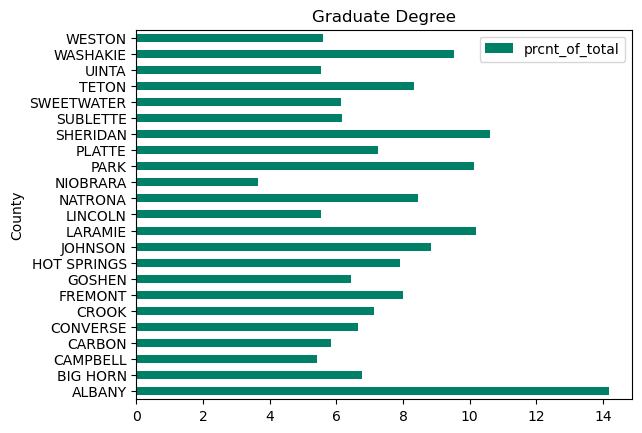

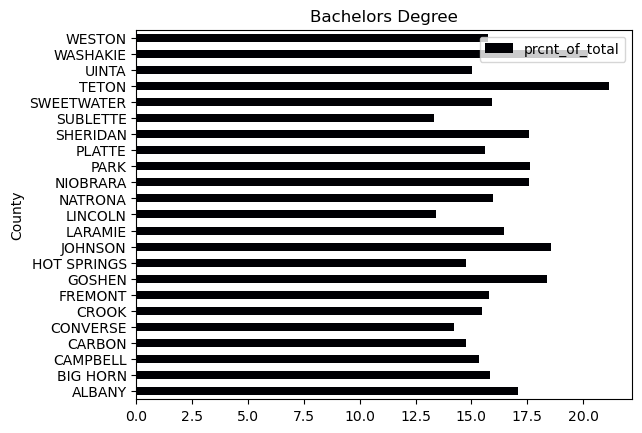

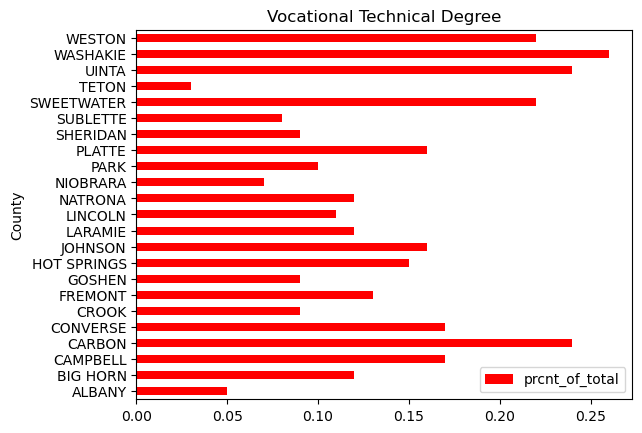

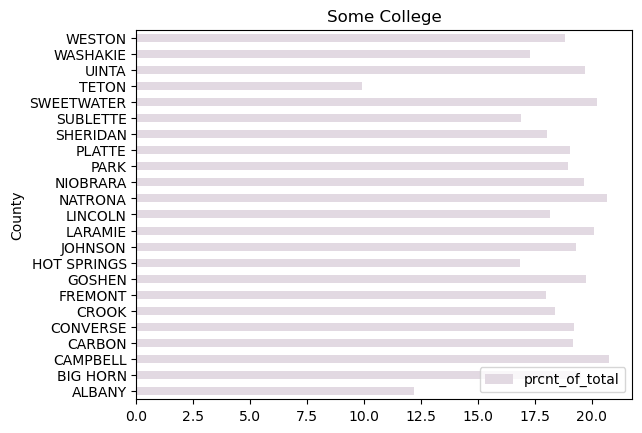

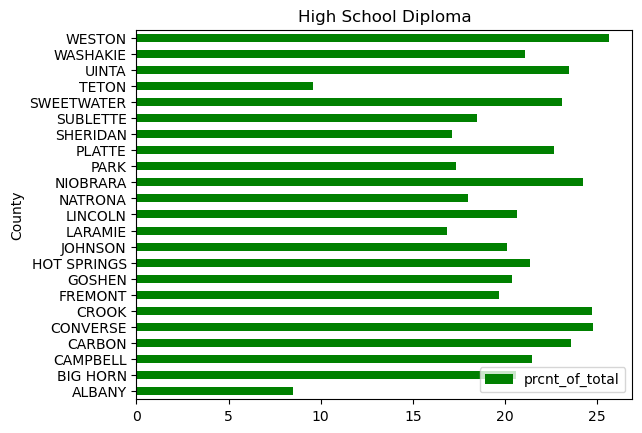

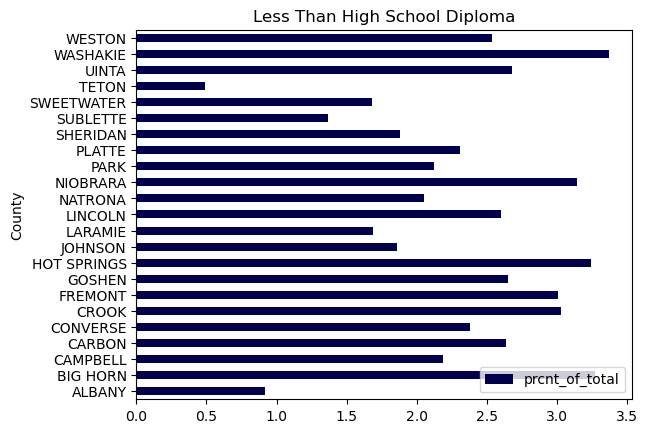

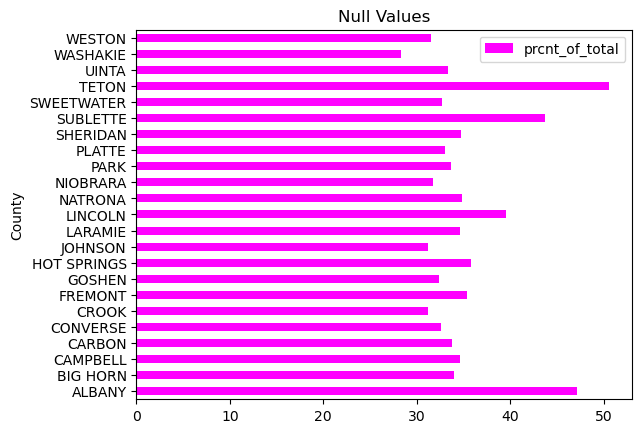

In [54]:
## visualize above

## distribution of grad degrees per county
grad_dgs_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Grad Degree")
grad_dgs_by_county_pd = grad_dgs_by_county.toPandas()
grad_dgs_by_county_pd.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='Graduate Degree')

## distribution of bach degrees per county
bach_dgs_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Bach Degree")
bach_dgs_by_county_pd = bach_dgs_by_county.toPandas()
bach_dgs_by_county_pd.plot.barh(x='County', y='prcnt_of_total', colormap='magma', title='Bachelors Degree')

## distribution of vocational technical degrees per county
voc_dgs_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Vocational Technical Degree")
voc_dgs_by_county_pd = voc_dgs_by_county.toPandas()
voc_dgs_by_county_pd.plot.barh(x='County', y='prcnt_of_total', colormap='autumn', title='Vocational Technical Degree')

## distribution of some college per county
some_col_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Some College")
some_col_by_county_pd = some_col_by_county.toPandas()
some_col_by_county_pd.plot.barh(x='County', y='prcnt_of_total', colormap='twilight', title='Some College')

## distribution of hs diploma per county
hs_dip_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "HS Diploma")
hs_dip_by_county_pd = hs_dip_by_county.toPandas()
hs_dip_by_county_pd.plot.barh(x='County', y='prcnt_of_total', colormap='ocean', title='High School Diploma')

## distribution of less than hs diploma per county
less_thn_hs_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Less Than HS Diploma")
less_thn_hs_by_county_pd = less_thn_hs_by_county.toPandas()
less_thn_hs_by_county_pd.plot.barh(x='County', y='prcnt_of_total', colormap='seismic', title='Less Than High School Diploma')

## distribution of null education level per county
null_ed_lvl_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Null")
null_ed_lvl_by_county_pd = null_ed_lvl_by_county.toPandas()
null_ed_lvl_by_county_pd.plot.barh(x='County', y='prcnt_of_total', colormap='spring', title='Null Values')

##### From these graphs, we are able to get more information about the highest level of education for voters in Wyoming counties, which will be helpful for us when taking a look at voter turnout:
- Albany County has the highest proportion of voters with Grad Degrees compared to the other WY counties
- Teton County has the highest proportion of voters with Bachelors Degrees compared to the other WY counties
- Washakie County has the highest proportion of voters with Vocational Technical Degrees compared to the other WY counties
- Campbell County has the highest proportion of voters with 'Some College' completed compared to the other WY counties
- Weston County has the highest proportion of voters with High School Diplomas compared to the other WY counties
- Washakie County has the highest proportion of voters with less than a High School Diploma compared to the other WY counties
- For all of the counties in Wyoming, about 25-50% of the voters are missing data for their highest level of  education

##### From this exploration, we can conclude which education level is the most prominent in each county for the state, and then compare that to how the county voted in a general election. We plan to do this with a select few states: some that typically vote 'Red', 'Blue', or some that typically 'swing' between both. This is where we plan to take our project in the future.